In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import modules.evaluate as evaluate
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
import modules.random_graph as random_graph
import math
import random
soleGraphs= ["ba1", "ba2", "ba3", "er1", "er2", "er3"]


realGraphs= ["contious_Africa", "contious_china", "contious_EU", "contious_usa", "mobility_german", "mobility_us"]

modelLoads= ["AA", "AB", "BA", "BB", "infer2018"]
weightModels= ["degree", "gravity", "identical"]
randomGraphs= ["ER", "BA", "WS", "RGG"]
seeds= [10, 11, 12, 13, 14]
strains= [1, 2, 3, 4]
denses= [0, -1, -2, -3, -4]
nodes= [50, 100, 200, 400]
intenses= [0, 1, 2, -1]

identicalfs= [2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1]# except 1e-2

commands1=set()
linuxThread= 3

In [2]:
def continious_to_sparcity(my_array, top= 400):
    # Flatten the array to a 1D array
    flat_array = my_array.flatten()

    # Sort the flattened array in descending order
    sorted_indices = np.argsort(flat_array)[::-1]

    # Set the top 400 elements to 1 and the rest to 0
    flat_array[sorted_indices[:top]] = 1
    flat_array[sorted_indices[top:]] = 0

    # Reshape the modified 1D array back to the original shape
    result_array = flat_array.reshape(my_array.shape)
    return result_array

def continious_to_sparcity_cols(my_matrix, topRow= 8):

    result_matrix = np.zeros_like(my_matrix)
    indices = np.argsort(my_matrix, axis=1)[:, -topRow:]  # Get indices of top 8 elements in each row
    row_indices = np.arange(my_matrix.shape[0])[:, None]  # Row indices to broadcast
    result_matrix[row_indices, indices] = 1
    
    return result_matrix

def analyse_signal(signal):
    maxIndex = np.argmax(signal, axis= 2)
    signalCombine= signal.reshape(signal.shape[0], signal.shape[1]*signal.shape[2])
    meanV= maxIndex.mean()
    varV= np.var(maxIndex)
    simMatrix= cosine_similarity(signalCombine)
    simMatrixSumAVg= simMatrix.sum()/signal.shape[0]/signal.shape[0]
    return meanV, varV, simMatrixSumAVg

def scatter_points(x, y, xLabel="x", yLabel="y"):
    plt.scatter(x, y)
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    pearson_corr = np.corrcoef(x, y)[0, 1]
    spearman_corr = np.corrcoef(np.argsort(x), np.argsort(y))[0, 1]
    kendall_corr, _ = kendalltau(x, y)
    print(f"Pearson correlation: {pearson_corr:.2f}, spearma correlation: {spearman_corr:.2f},  kendall correlation: {kendall_corr:.2f}")


(100, 4, 47)


(24.145, 61.568975, 0.2879723876953125)

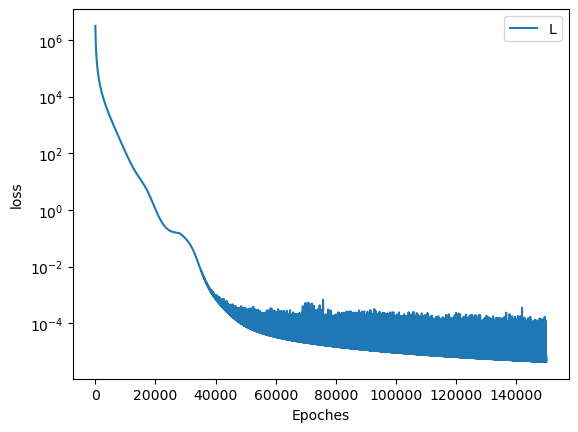

In [5]:
identicalf= 0.01

node= 100

strain= 4

#AA_RGG_identical_12_2_-1_0_100_10.0_150000
#AA_ER_identical_13_4_-1_0_100_10.0_150000
#AA_WS_identical_11_1_-1_0_100_10.0_150000
#AA_WS_identical_11_4_-1_0_100_10.0_150000

fileName= f"results/AA/AA_RGG_identical_{13}_{strain}_-1_0_100_{identicalf*1000}_150000.npz"
IMatrix= torch.eye(node, device= "cpu")
npzfile = np.load(fileName)
loss= npzfile['loss']
taus= npzfile["taus"]
signal= npzfile['signal']
PreAnp= npzfile['Apre']
Awnp= npzfile['A']

plt.plot(loss)
plt.yscale("log")
plt.xlabel("Epoches")
plt.ylabel("loss")
plt.legend("Loss")


print(signal.shape)

analyse_signal(signal)

In [6]:
#AA_WS_identical_11_4_-1_0_100_10.0_150000

identicalf= 0.01
node= 100
#Is - jaccard index
cosinesL= []
spectralsL= []
edgesL= []
jaccardsL= []
meanVL= [] 
varVL= [] 
simMatrixSumAVgL= []
for randomGraph in randomGraphs:
    for dense in denses:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        for seed in seeds:
            try:
                fileName= f"results/AA/AA_{randomGraph}_identical_{seed}_{strain}_-1_{dense}_{node}_{identicalf*1000}_150000.npz"
                IMatrix= torch.eye(node, device= "cpu")
                npzfile = np.load(fileName)
            except:
                print(fileName)
                continue
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            signal= npzfile['signal']
            meanV, varV, simMatrixSumAVg= analyse_signal(signal)
            meanVL.append(meanV)
            varVL.append(varV)
            simMatrixSumAVgL.append(simMatrixSumAVg)
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosinesL.append(evaluate.cosine_similarity(Aw, PreA).item())
            spectralsL.append(evaluate.spectral_analysis(Aw, PreA).item())
            edgesL.append(evaluate.recall(Aw, PreA).item())
            jaccardsL.append(evaluate.jaccard_index(Aw, PreA).item())

Pearson correlation: 0.74, spearma correlation: 0.51,  kendall correlation: 0.57


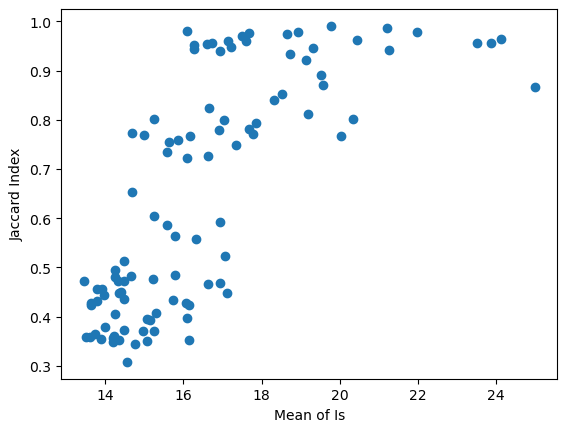

In [54]:
scatter_points(meanVL, jaccardsL, "Mean of Is","Jaccard Index" )

Pearson correlation: 0.69, spearma correlation: 0.65,  kendall correlation: 0.72


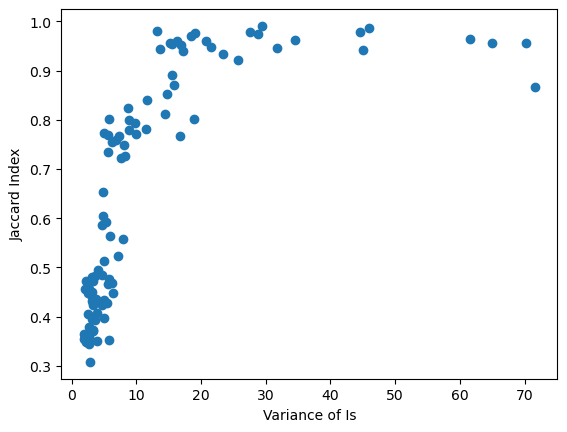

In [55]:
scatter_points(varVL, jaccardsL, "Variance of Is", "Jaccard Index" )

Pearson correlation: -0.94, spearma correlation: -0.71,  kendall correlation: -0.74


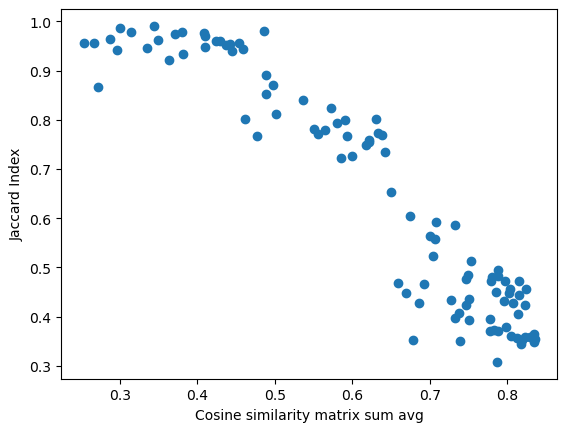

In [56]:
scatter_points(simMatrixSumAVgL, jaccardsL, "Cosine similarity matrix sum avg", "Jaccard Index" )

In [7]:
#train svm classier
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.svm import SVR  # For SVM regression

model = SVR(kernel='rbf')  # Adjust kernel as needed
x_train_np= np.stack(meanVL)
y_train_np= np.stack(varVL)
z_train_np= np.stack(simMatrixSumAVgL)
g_train_np= np.stack(jaccardsL)
model.fit(np.stack([x_train_np, y_train_np, z_train_np], axis=1), g_train_np)

g_pred_np = model.predict(np.stack([x_train_np, y_train_np, z_train_np], axis=1))

print(np.mean(np.abs(g_train_np-g_pred_np)))
print(np.var(np.abs(g_train_np-g_pred_np)))

NameError: name 'meanVL' is not defined

In [99]:
import modules.random_graph as random_graph
import modules.pramameters as pramameters
import modules.utils as utils
import modules.weight as weight
import modules.A_mat as A_mat
import modules.population as population
import modules.simulation as simulation
import argparse
import math
from tqdm import tqdm

#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
#preset
paras.modelLoad= "AA"
paras.randomGraph= "ER"
paras.weightModel= "identical"
paras.epoches= 100000
paras.intense= 0#0:
paras.plot= "spring"
paras.strains= 4
paras.dense= 2
paras.identicalf= 0.01
paras.n= 100
paras.seed= 11

if paras.dense<=0:
    paras.dense= int(math.log(paras.n))-paras.dense
    print(paras.dense)

lenths= []

for i in tqdm(range(2, 40)):
    paras.dense= i

    if paras.randomGraph not in randomGraphs:
        print("haha")
        A, G= random_graph.read_from_file("graphs/"+paras.randomGraph+".npy")
    else:
        A, G= random_graph.get_ER_random_contact(paras.n, paras.dense)

    P= population.population(paras.n)

    Aw= weight.identical_model(A, paras.identicalf)

    Zmat= A_mat.create_A_mat(Aw, P)

    R0s_taus= [[random.uniform(paras.R0Mean-paras.R0Std, paras.R0Mean+paras.R0Std), 
                random.uniform(paras.tauMean-paras.tauStd, paras.tauMean+paras.tauStd)] for _ in range(40)]
    paras.R0s=  [ R0s_taus[i][0] for i in range(40)]
    paras.taus= [ R0s_taus[i][1] for i in range(40)]

    deltaSsTensor= simulation.multi_strains(G, paras, Zmat, intense= paras.intense, lower= 5)
    deltaSs= deltaSsTensor.sum(dim= -1, keepdim= True)
    propition= deltaSsTensor/(deltaSs+1e-8)
    deltaSs= deltaSs.squeeze()#(1, 2, 20), dim of nodes, dim of heads, dim of signal
    divide= deltaSsTensor.transpose(1, 2)

    meanV, varV, simMatrixSumAVg= analyse_signal(divide.numpy())
    lenths.append(divide.shape[-1])
print(meanV, varV, simMatrixSumAVg)
print(divide.shape[-1])
print(model.predict(np.array([[meanV, varV, simMatrixSumAVg]])))


100%|██████████| 38/38 [00:04<00:00,  8.05it/s]

9.1275 0.17124374999999997 0.988134765625
12
[0.45279788]


In [46]:
# from datetime import datetime
# timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# # Specify the file path
# file_path = f"graphs/er3.npy"
# # Save the matrix to a file
# np.save(file_path, A.numpy())
# print(f"NumPy matrix saved to file: {file_path}")

NumPy matrix saved to file: graphs/er3.npy


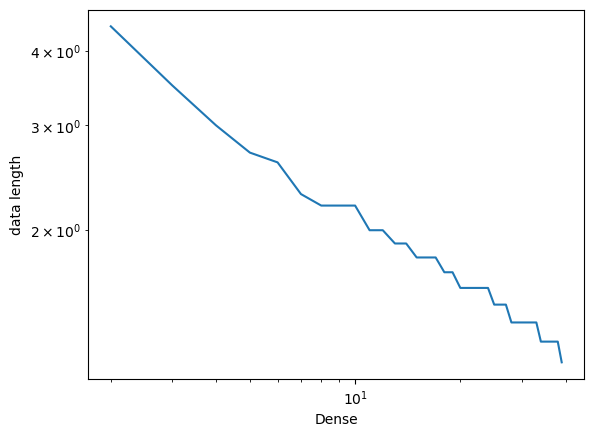

In [101]:
plt.plot([i for i in range(2, 40)], [i/10 for i in lenths])#y=log(x)
plt.xlabel("Dense")
plt.ylabel("data length")
plt.xscale("log")
plt.yscale("log")

In [20]:

identicalf= 0.01
node= 100
strain= 4

#Performance on different models

for randomGraph in randomGraphs:
    cosinesList= []
    spectralsList= []
    edgesList= []
    jaccardsList= []
    for modelLoad in modelLoads:
        cosines= 0
        spectrals= 0
        edges= 0
        jaccards= 0
        minus= 0
        for seed in seeds:
            try:
                fileName= f"results/{modelLoad}/{modelLoad}_{randomGraph}_identical_{seed}_{strain}_-1_0_{node}_{identicalf*1000}_150000.npz"
                IMatrix= torch.eye(node, device= "cpu")
                npzfile = np.load(fileName)
            except:
                print(fileName)
                minus+=1
                continue
            # Access the arrays in the NPZ file
            Awnp= npzfile['A']
            PreAnp= npzfile['Apre']
            Aw = torch.tensor(Awnp)
            PreA = torch.tensor(PreAnp)
            links= int(torch.sum(Aw)/identicalf)  
            Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
            PreAs= torch.tensor(continious_to_sparcity(PreAnp, links))+IMatrix
            cosines+= evaluate.cosine_similarity(Aw, PreA)
            spectrals+= evaluate.spectral_analysis(Aws, PreAs)
            edges+= evaluate.recall(Aws, PreAs)
            jaccards+= evaluate.jaccard_index(Aws, PreAs)
        cosines/= len(seeds)-minus
        spectrals/= len(seeds)-minus
        edges/= len(seeds)-minus
        jaccards/= len(seeds)-minus
        cosinesList.append(f"{cosines:.2f}")
        spectralsList.append(f"{spectrals:.2f}")
        edgesList.append(f"{edges:.2f}")
        jaccardsList.append(f"{jaccards:.2f}")
        #print(f"{cosines:.2f}\t{spectrals:.2f}\t{edges:.2f}\t{jaccards:.2f}", end="\t")
    print("\t".join(cosinesList)+"\t"+"\t".join(spectralsList)+"\t"+"\t".join(edgesList)+"\t"+"\t".join(jaccardsList))
    #print()

0.65	nan	0.18	0.14	0.15	0.19	0.37	0.22	0.26	0.23	0.84	0.46	0.48	0.47	0.48	0.73	0.30	0.32	0.31	0.32
0.74	nan	0.18	0.12	0.13	0.25	0.41	0.25	0.25	0.21	0.96	0.48	0.51	0.49	0.49	0.92	0.32	0.34	0.32	0.32
0.89	nan	0.27	0.24	0.23	0.78	0.35	0.18	0.22	0.25	1.12	0.47	0.56	0.51	0.51	1.26	0.30	0.39	0.35	0.34
0.96	nan	0.30	0.33	0.31	0.87	0.39	0.19	0.28	0.24	1.17	0.48	0.59	0.58	0.56	1.41	0.31	0.42	0.41	0.39


In [13]:
print(modelLoads)

['AA', 'AB', 'BA', 'BB', 'infer2018']


In [8]:
def general_evaluate(evaluateMeth=[], attriIndex= 0, attributionL=[] ,seed= 100001, CompareWithRandom= False, seeds= [], randomGraphs= []):
    random.seed(seed)
    strain= 4
    intense= -1
    dense= 0
    node= 100
    identicalf= 0.01
    epoches= 150000
    modelLoad= "AA"
    atts= [strain, intense, dense, node, identicalf, epoches, modelLoad]
    auc_rocs_aws= []
    auc_rocs_preA= []
    evaluateLists= []
    for randomGraph in randomGraphs:
        evaluateList= []
        for attribution in attributionL: 
            atts[attriIndex]= attribution
            evaluateNp= [0 for _ in range(len(evaluateMeth))]
            auc_rocs_aws_temp= []
            auc_rocs_preA_temp= []
            for seed in seeds:
                try:
                    fileName= f"results/{atts[6]}/{atts[6]}_{randomGraph}_identical_{seed}_{atts[0]}_{atts[1]}_{atts[2]}_{atts[3]}_{atts[4]*1000}_{atts[5]}.npz"
                    npzfile = np.load(fileName)
                except:
                    print(fileName)
                    continue
                # Access the arrays in the NPZ file
                Awnp= npzfile['A']
                node= Awnp.shape[0]
                IMatrix= torch.eye(node, device= "cpu")
                
                PreAnp= npzfile['Apre']
                if CompareWithRandom:
                    denseTrue= int(math.log(node))-atts[2]
                    A, _= random_graph.get_ER_random_contact(node, denseTrue, shuffle= True)
                    PreAnp= A.numpy()
                Aw = torch.tensor(Awnp)
                PreA = torch.tensor(PreAnp)
                
                links= int(torch.sum(Aw)/identicalf)  
                Aws= torch.tensor(continious_to_sparcity(Awnp, links))+IMatrix
                for i, method in enumerate(evaluateMeth):
                    evaluateNp[i]+= method(Aw, PreA)
                auc_rocs_aws_temp.append(Aws-IMatrix)
                auc_rocs_preA_temp.append(PreA)
            for i, _ in enumerate(evaluateMeth):
                evaluateNp[i]= round(evaluateNp[i].item()/len(seeds), 2)
            evaluateList.append(evaluateNp)
            auc_rocs_aws.append(torch.stack(auc_rocs_aws_temp))
            auc_rocs_preA.append(torch.stack(auc_rocs_preA_temp))
        strPrint=""
        evaluateLists.append(evaluateList)
        zipList= list(zip(*evaluateList))
        for i, _ in enumerate(evaluateMeth):#attributionL, evaluateList(evaluateMeth, zipList)
            strPrint+= "\t".join([str(j) for j in zipList[i]])+"\t"
        print(strPrint)
    return auc_rocs_aws, auc_rocs_preA, evaluateLists

def plot_evaluate(xs, evaluateArray, xLabel, yLabels, legends, xScale="linear", yScale="linear"):
    col= 2
    fig, axs = plt.subplots(int((len(yLabels)+col-1)/col), col, figsize=(col*5, 5*int((len(yLabels)+col-1)/col)))
    for i, yLabel in enumerate(yLabels):
        axs[int(i/col), i%col].plot(xs , evaluateArray[:, :, i].T)
        axs[int(i/col), i%col].set_xlabel(xLabel)
        axs[int(i/col), i%col].set_ylabel(str(yLabel))
        axs[int(i/col), i%col].legend(legends)
        axs[int(i/col), i%col].set_xscale(xScale)
        axs[int(i/col), i%col].set_yscale(yScale)


0.08	0.06	0.09	0.07	0.08	0.12	0.08	0.16	-0.01	0.06	0.18	0.17	0.19	0.18	0.18	0.1	0.09	0.1	0.1	0.1	-0.0	-0.02	0.01	-0.01	-0.0	0.85	0.85	0.85	0.85	0.85	
0.08	0.08	0.08	0.08	0.08	0.23	0.18	0.18	-0.03	0.15	0.18	0.19	0.19	0.18	0.19	0.1	0.1	0.1	0.1	0.1	-0.0	0.01	0.01	-0.0	0.0	0.86	0.86	0.86	0.86	0.86	
0.08	0.08	0.07	0.07	0.07	0.06	0.02	0.09	0.08	0.07	0.18	0.18	0.18	0.18	0.18	0.1	0.1	0.1	0.1	0.1	0.0	0.0	-0.01	-0.01	-0.01	0.85	0.85	0.85	0.85	0.85	
0.08	0.08	0.09	0.08	0.08	0.04	0.06	0.18	0.06	0.15	0.18	0.18	0.19	0.18	0.18	0.1	0.1	0.1	0.1	0.1	0.0	-0.0	0.01	0.0	0.0	0.85	0.85	0.85	0.85	0.85	


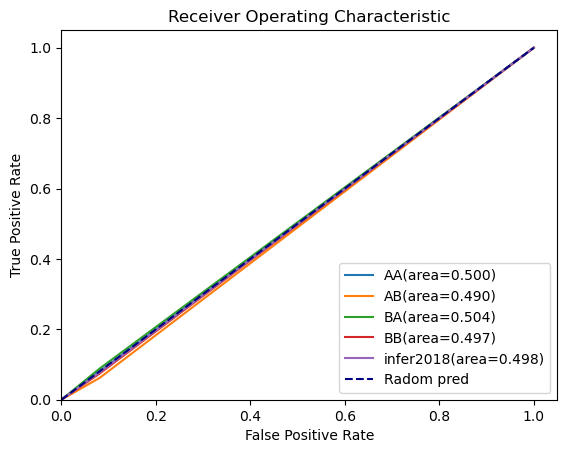

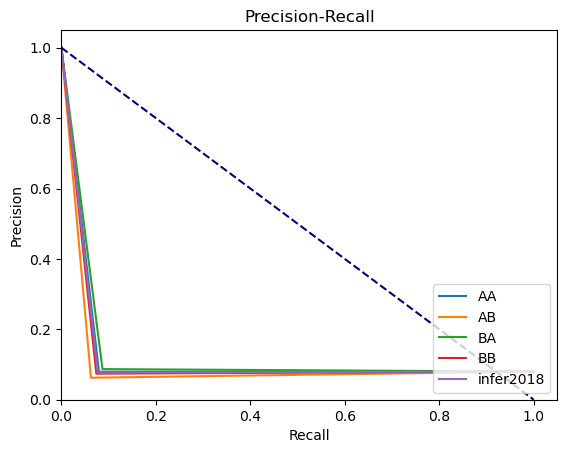

In [11]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index,evaluate.pearson_correlation, evaluate.accuracy]
attriIndex= 6
attributionL= modelLoads
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= attriIndex, attributionL= attributionL ,seed= 100001, CompareWithRandom= True, seeds=seeds, randomGraphs= randomGraphs)
evaluateArray= np.array(evaluateLists)
startIn= 0*len(attributionL)
endIn= len(attributionL)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
yLabels= [str(i).split()[1] for i in evaluateMeth]

0.59	0.91	0.96	0.99	0.36	0.73	0.81	0.85	0.58	0.92	0.97	1.0	0.41	0.85	0.95	1.0	0.53	0.9	0.96	0.99	0.9	0.98	0.99	1.0	
0.69	0.93	0.99	1.0	0.55	0.81	0.71	0.98	0.68	0.95	1.0	1.0	0.52	0.9	1.0	1.0	0.64	0.93	0.99	1.0	0.9	0.98	1.0	1.0	
0.75	0.97	0.99	1.0	0.17	0.35	0.63	0.58	0.77	0.98	1.0	1.0	0.63	0.96	1.0	1.0	0.7	0.96	0.99	1.0	0.92	0.99	1.0	1.0	
0.63	0.94	0.99	0.98	0.46	0.78	0.82	0.84	0.65	0.95	1.0	0.99	0.49	0.9	0.99	0.98	0.58	0.93	0.98	0.98	0.92	0.99	1.0	1.0	
0.26	0.6	0.8	0.9	0.53	0.6	0.68	0.63	0.25	0.59	0.79	0.91	0.14	0.42	0.65	0.84	0.21	0.59	0.79	0.89	0.96	0.98	0.99	1.0	
0.62	0.8	0.88	0.88	0.39	0.67	0.28	0.35	0.57	0.78	0.87	0.87	0.4	0.64	0.77	0.77	0.55	0.77	0.87	0.86	0.89	0.94	0.97	0.97	


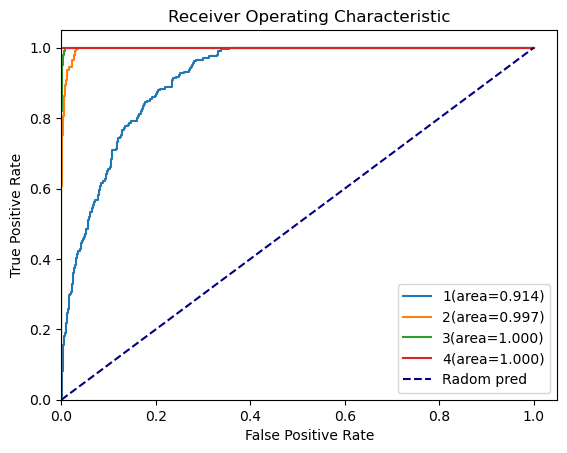

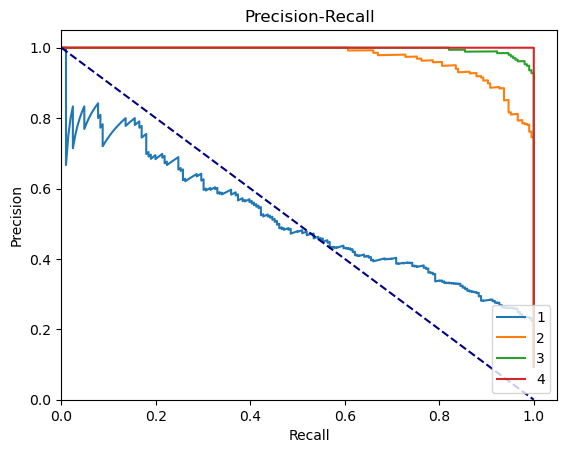

In [12]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index, evaluate.pearson_correlation, evaluate.accuracy]
attriIndex= 0 
attributionL= strains
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 0, attributionL= strains ,seed= 100001, CompareWithRandom= False, seeds=[11], randomGraphs= realGraphs)
evaluateArray= np.array(evaluateLists)
startIn= 0*len(attributionL)
endIn= len(attributionL)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
yLabels= [str(i).split()[1] for i in evaluateMeth]

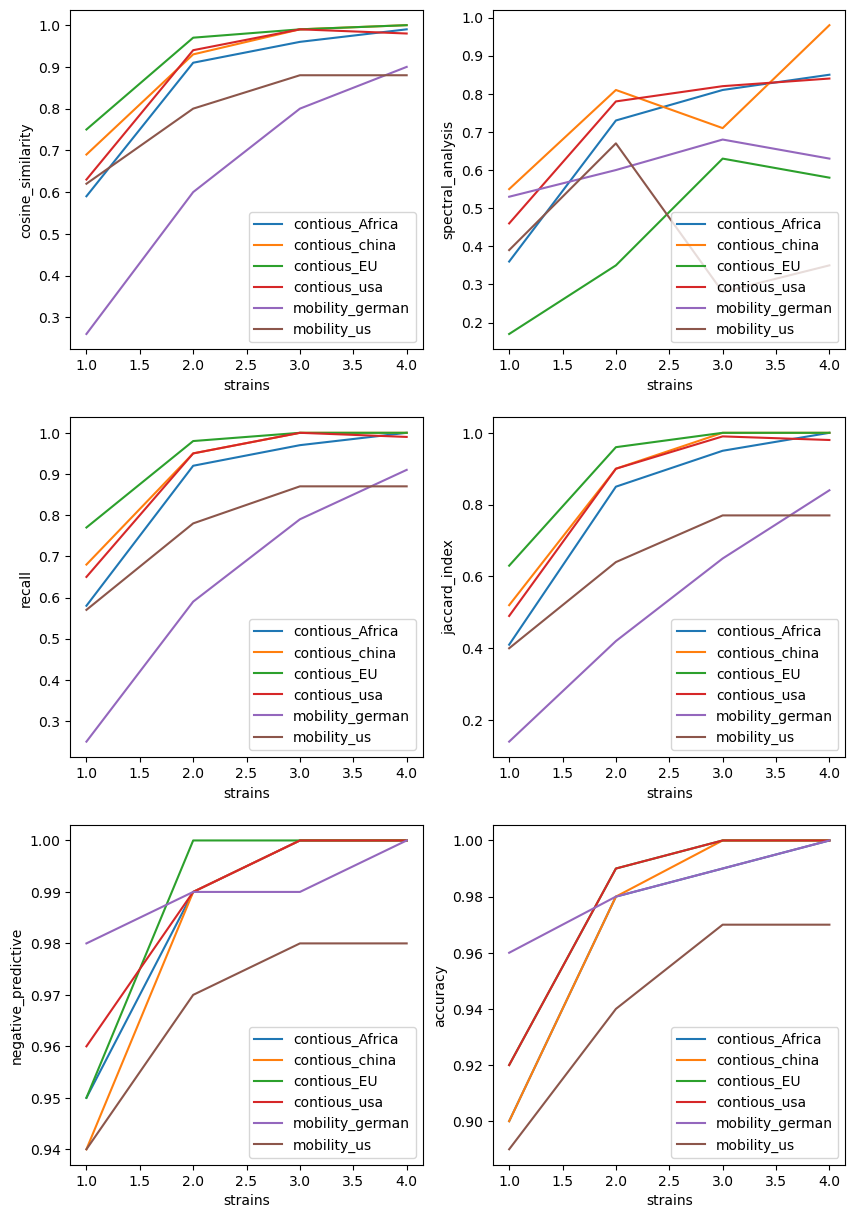

In [9]:
plot_evaluate( strains, evaluateArray, "strains", yLabels, realGraphs)

0.31	0.5	0.58	0.65	25.76	12.21	11.09	9.89	0.35	0.32	0.29	0.27	0.19	0.29	0.36	0.43	0.22	0.43	0.53	0.61	0.08	0.14	0.19	0.25	
0.43	0.6	0.65	0.74	12.16	10.33	9.35	7.75	0.31	0.28	0.26	0.22	0.28	0.39	0.45	0.56	0.35	0.55	0.61	0.72	0.13	0.2	0.25	0.34	
0.24	0.7	0.82	0.89	81.27	8.54	5.88	4.21	0.35	0.25	0.18	0.13	0.2	0.5	0.7	0.83	0.18	0.67	0.81	0.88	0.07	0.31	0.47	0.59	
0.44	0.84	0.92	0.96	56.33	5.63	3.39	2.29	0.3	0.17	0.12	0.07	0.34	0.72	0.86	0.94	0.39	0.82	0.91	0.95	0.17	0.5	0.66	0.75	


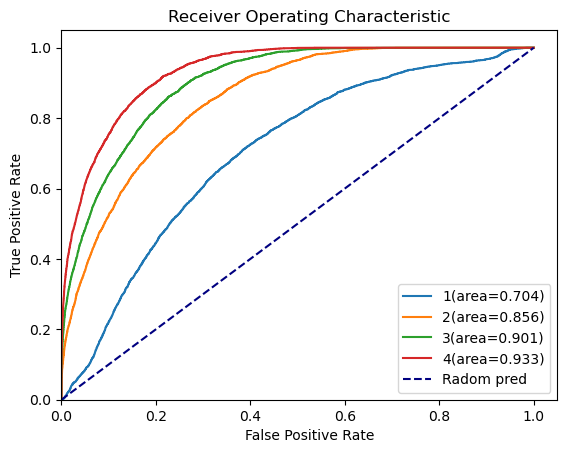

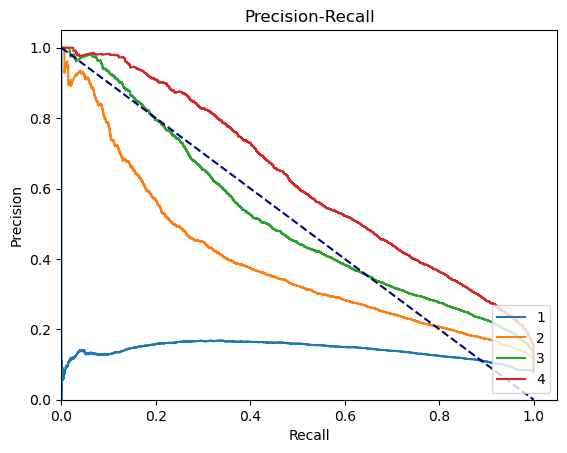

In [32]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.graph_edit_distance, evaluate.normalized_hamming_distance, evaluate.jaccard_index,evaluate.pearson_correlation, evaluate.jaccard_similarity]
attriIndex= 0 
attributionL= strains
auc_rocs_aws, auc_rocs_preA, _= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= attriIndex, attributionL= attributionL ,seed= 100001, CompareWithRandom= False, seeds= seeds, randomGraphs= randomGraphs)

startIn= 0*len(attributionL)
endIn= len(attributionL)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)

0.66	0.66	0.64	0.65	0.25	0.19	0.21	0.2	0.62	0.62	0.6	0.6	0.45	0.45	0.43	0.43	0.96	0.96	0.96	0.96	0.93	0.93	0.93	0.93	
0.75	0.75	0.74	0.74	0.3	0.37	0.28	0.21	0.73	0.73	0.71	0.72	0.58	0.58	0.56	0.56	0.97	0.97	0.97	0.97	0.95	0.95	0.95	0.95	
0.89	0.9	0.9	0.89	0.72	0.73	0.77	0.78	0.9	0.92	0.92	0.91	0.83	0.84	0.84	0.83	0.99	0.99	0.99	0.99	0.98	0.98	0.98	0.98	
0.97	0.97	0.95	0.96	0.86	0.82	0.82	0.83	0.98	0.98	0.96	0.97	0.96	0.97	0.92	0.94	1.0	1.0	1.0	1.0	1.0	1.0	0.99	0.99	


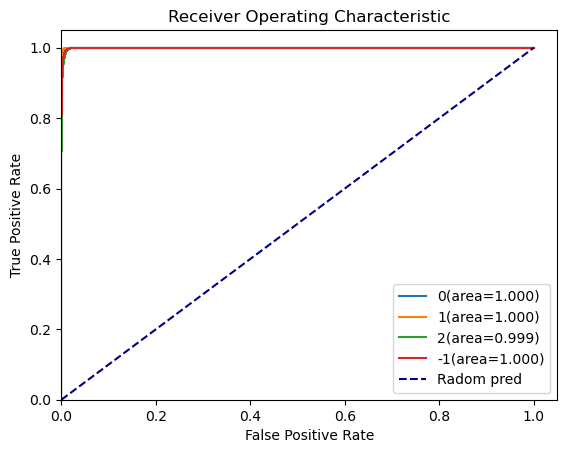

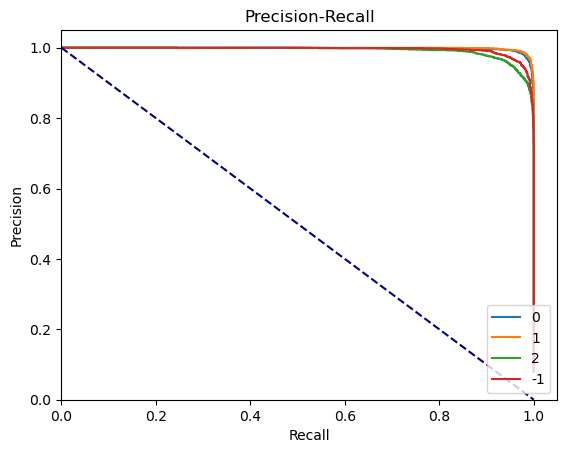

In [21]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index,evaluate.negative_predictive, evaluate.accuracy]
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 1, attributionL=intenses ,seed= 100001, CompareWithRandom= False, seeds= seeds, randomGraphs= randomGraphs)
evaluateArray= np.array(evaluateLists)

startIn= 3*len(attributionL)
endIn= len(attributionL)+startIn
yLabels= [str(i).split()[1] for i in evaluateMeth]

evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)

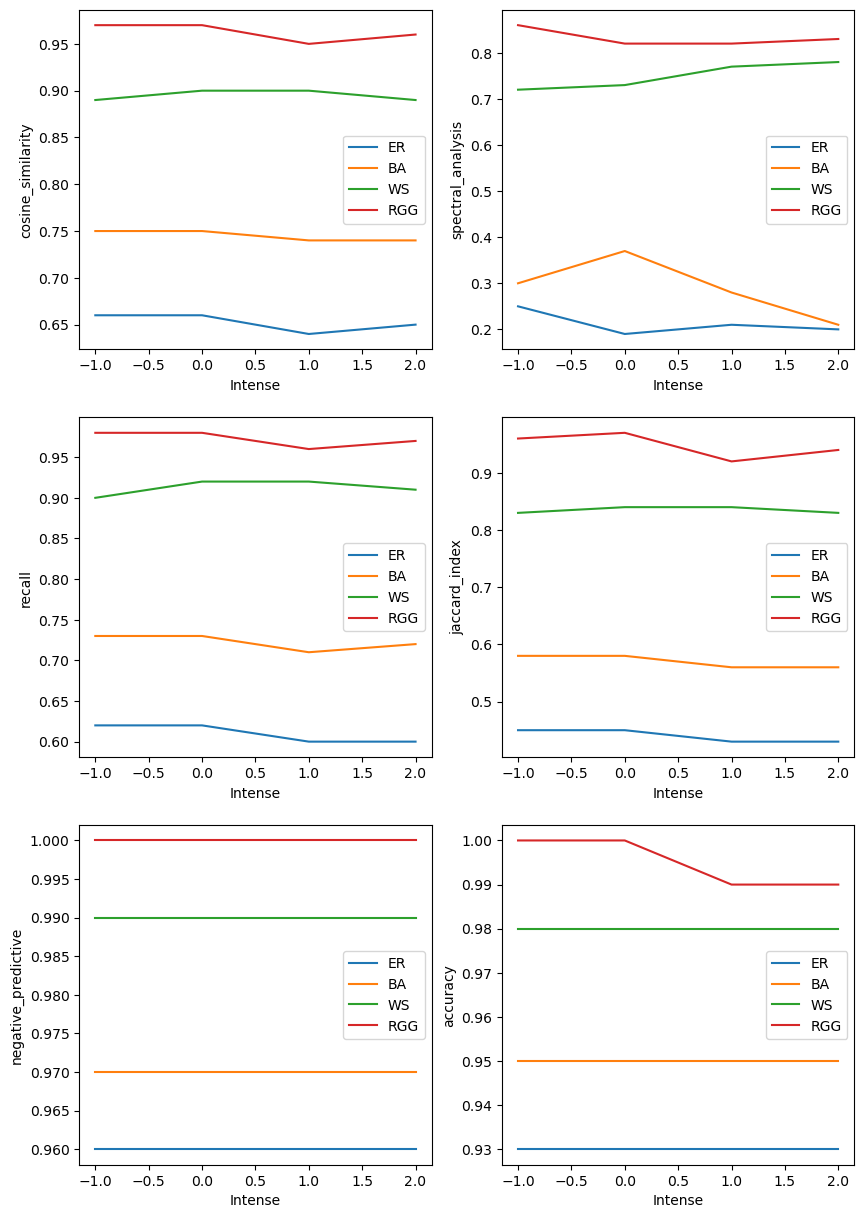

In [24]:
plot_evaluate([-1, 0, 1, 2], evaluateArray, "Intense", yLabels, randomGraphs)

0.65	0.62	0.6	0.6	0.6	0.2	0.22	0.32	0.19	0.33	0.6	0.57	0.53	0.53	0.53	0.43	0.4	0.36	0.36	0.36	0.96	0.95	0.93	0.92	0.9	0.93	0.9	0.88	0.86	0.84	
0.74	0.68	0.69	0.67	0.66	0.21	0.38	0.43	0.36	0.48	0.72	0.64	0.65	0.62	0.61	0.56	0.47	0.48	0.45	0.44	0.97	0.96	0.95	0.94	0.93	0.95	0.92	0.91	0.89	0.88	
0.89	0.88	0.86	0.85	0.83	0.78	0.75	0.83	0.83	0.83	0.91	0.89	0.87	0.86	0.84	0.83	0.81	0.78	0.75	0.72	0.99	0.99	0.98	0.97	0.97	0.98	0.98	0.97	0.96	0.94	
0.96	0.96	0.96	0.95	0.95	0.83	0.83	0.84	0.88	0.9	0.97	0.98	0.98	0.98	0.98	0.94	0.96	0.97	0.96	0.96	1.0	1.0	1.0	1.0	1.0	0.99	1.0	1.0	0.99	0.99	


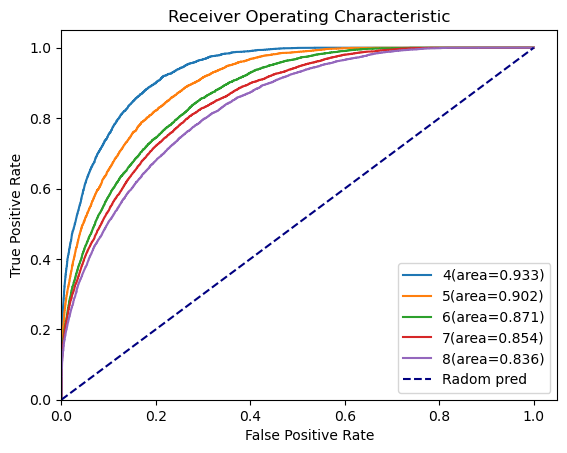

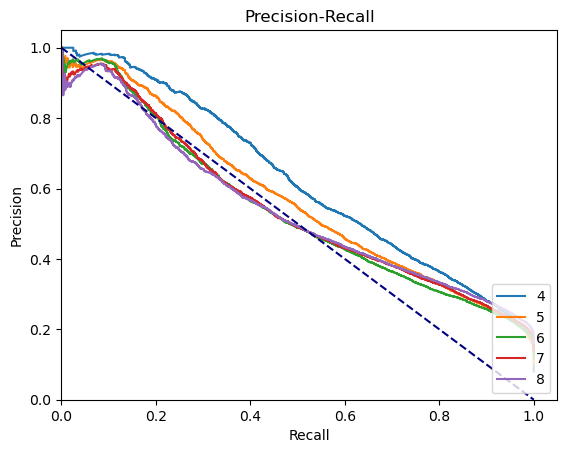

In [7]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index,evaluate.negative_predictive, evaluate.accuracy]
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 2, attributionL= denses ,seed= 100001, CompareWithRandom= False, seeds= seeds, randomGraphs= randomGraphs)
evaluateArray= np.array(evaluateLists)
attributionL= denses
startIn= 0*len(attributionL)
endIn= len(attributionL)+startIn
yLabels= [str(i).split()[1] for i in evaluateMeth]
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], int(math.log(100))-np.array(denses))
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], int(math.log(100))-np.array(denses))

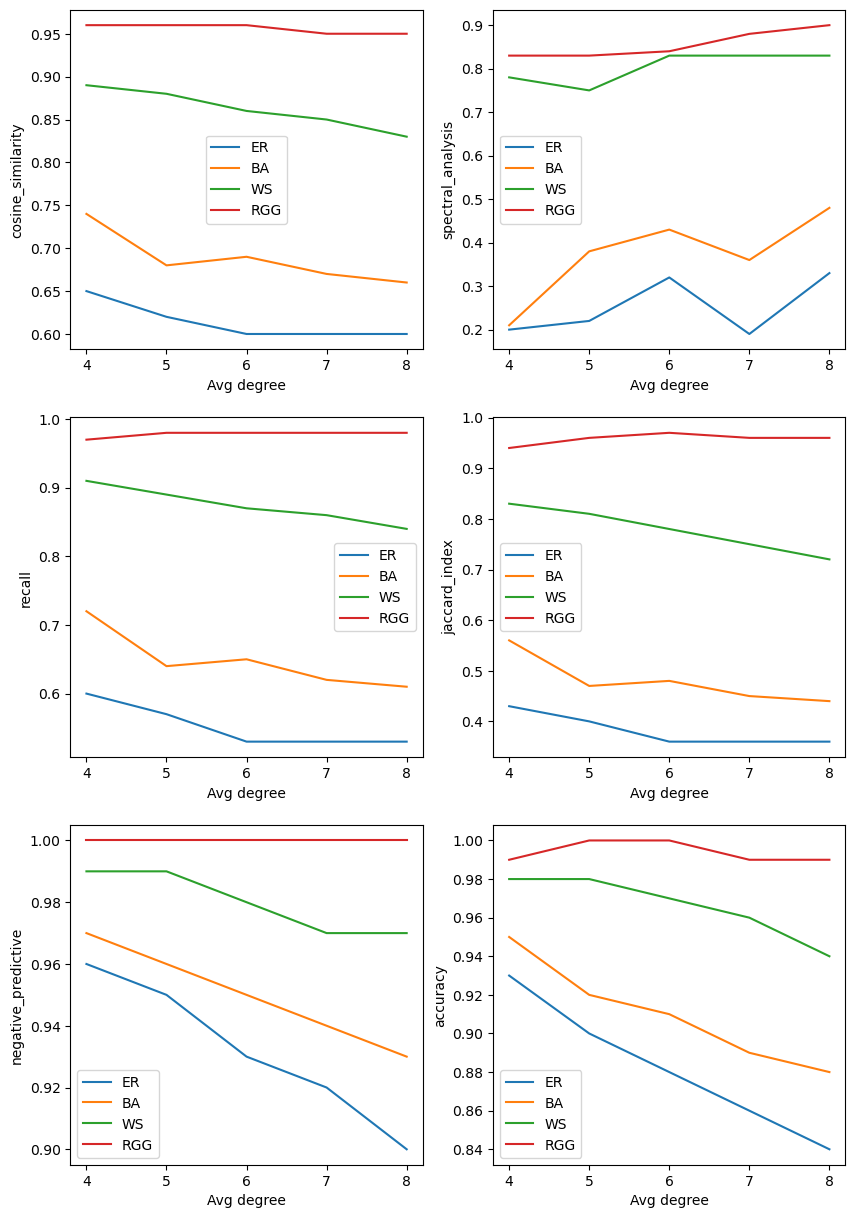

In [8]:
plot_evaluate(int(math.log(100))-np.array(denses), evaluateArray, "Avg degree", yLabels, randomGraphs)

In [9]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index, evaluate.negative_predictive, evaluate.accuracy]
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 3, attributionL= nodes ,seed= 100001, CompareWithRandom= False, seeds= seeds, randomGraphs= randomGraphs)
evaluateArray= np.array(evaluateLists)
yLabels= [str(i).split()[1] for i in evaluateMeth]

0.87	0.65	0.5	0.38	0.18	0.2	0.12	0.21	0.86	0.6	0.45	0.34	0.76	0.43	0.29	0.2	0.98	0.96	0.97	0.98	0.96	0.93	0.94	0.96	
0.88	0.74	0.58	0.5	0.45	0.21	0.12	0.22	0.89	0.72	0.55	0.47	0.81	0.56	0.38	0.31	0.98	0.97	0.97	0.99	0.97	0.95	0.95	0.97	
0.97	0.89	0.79	0.74	0.76	0.78	0.76	0.68	0.98	0.91	0.79	0.73	0.97	0.83	0.65	0.58	1.0	0.99	0.99	0.99	1.0	0.98	0.98	0.99	
0.98	0.96	0.94	0.92	0.9	0.83	0.77	0.78	0.99	0.97	0.96	0.93	0.98	0.94	0.92	0.88	1.0	1.0	1.0	1.0	1.0	0.99	1.0	1.0	


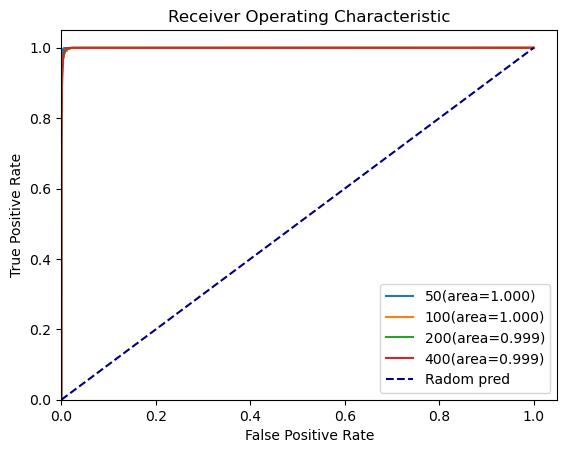

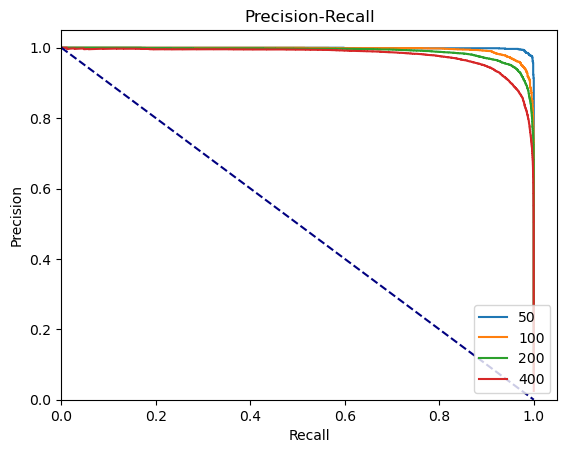

In [153]:
startIn= 3*len(nodes)
endIn= len(nodes)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], nodes)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], nodes)

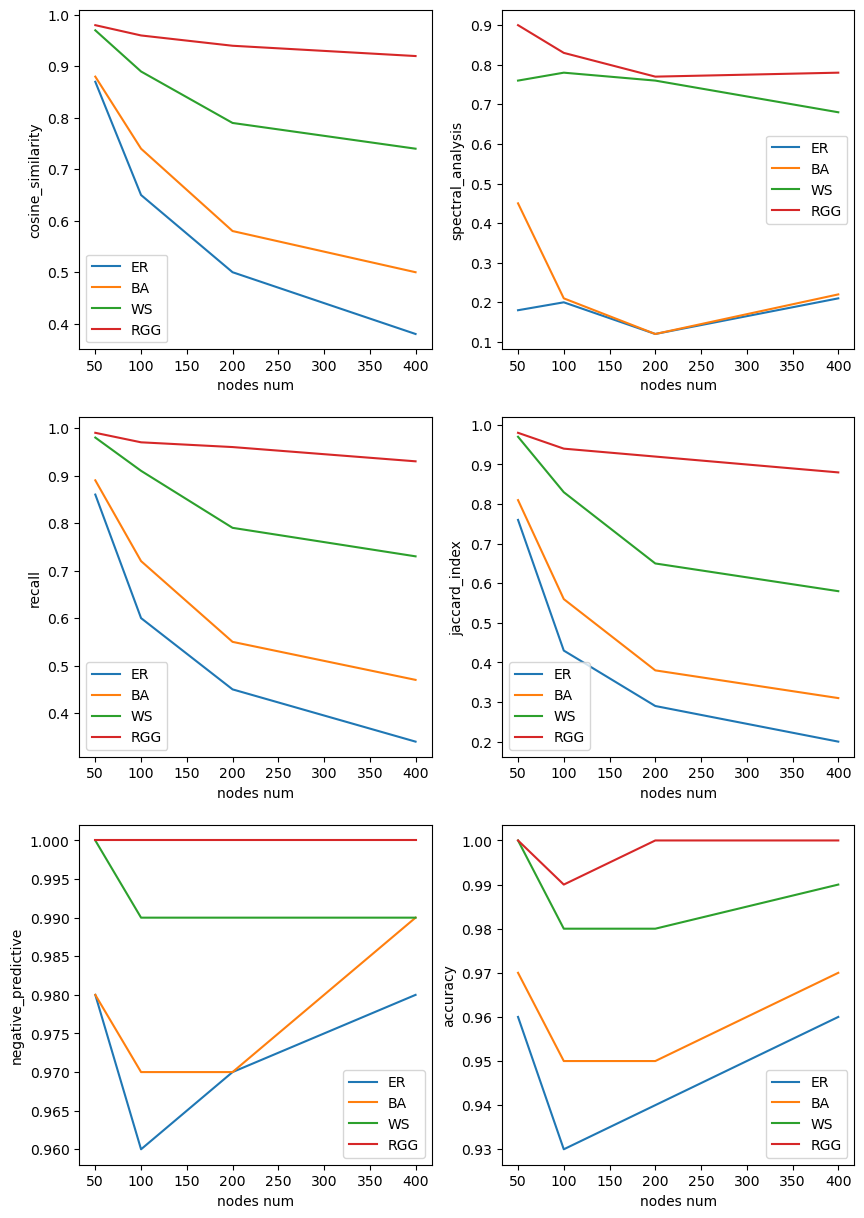

In [10]:
plot_evaluate(nodes, evaluateArray, "nodes num", yLabels, randomGraphs)

In [11]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index, evaluate.negative_predictive, evaluate.accuracy]
attriIndex= 1 
attributionL= intenses
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 1, attributionL= intenses ,seed= 100001, CompareWithRandom= False)
evaluateArray= np.array(evaluateLists)
yLabels= [str(i).split()[1] for i in evaluateMeth]

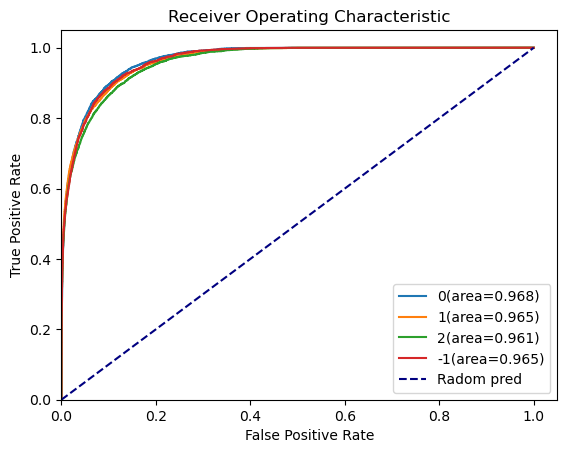

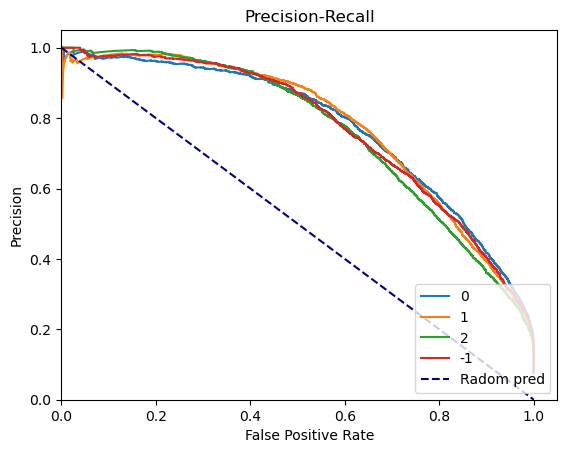

In [70]:
startIn= 1*len(attributionL)
endIn= len(attributionL)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], attributionL)

In [12]:
#[strain, intense, dense, node, identicalf, epoches]
evaluateMeth= [evaluate.cosine_similarity, evaluate.spectral_analysis, evaluate.recall, evaluate.jaccard_index, evaluate.negative_predictive, evaluate.accuracy]
auc_rocs_aws, auc_rocs_preA, evaluateLists= general_evaluate(evaluateMeth= evaluateMeth, attriIndex= 4, attributionL= identicalfs, seed= 100001, CompareWithRandom= False, seeds= seeds, randomGraphs= randomGraphs)
evaluateArray= np.array(evaluateLists)
yLabels= [str(i).split()[1] for i in evaluateMeth]

0.58	0.62	0.66	0.67	0.66	0.65	0.64	0.62	0.29	0.22	0.25	0.17	0.2	0.19	0.2	0.24	0.19	0.24	0.55	0.59	0.62	0.63	0.63	0.6	0.59	0.57	0.4	0.38	0.42	0.46	0.46	0.46	0.43	0.42	0.4	0.25	0.96	0.96	0.96	0.96	0.96	0.96	0.96	0.96	0.94	0.92	0.93	0.93	0.93	0.93	0.93	0.93	0.92	0.89	
0.62	0.7	0.71	0.74	0.74	0.74	0.74	0.56	0.28	0.34	0.3	0.3	0.2	0.3	0.21	0.3	0.21	0.25	0.61	0.69	0.7	0.72	0.72	0.72	0.71	0.64	0.43	0.44	0.52	0.54	0.57	0.56	0.56	0.55	0.48	0.27	0.96	0.97	0.97	0.97	0.97	0.97	0.97	0.97	0.95	0.93	0.95	0.95	0.95	0.95	0.95	0.95	0.94	0.9	
0.81	0.88	0.9	0.91	0.9	0.89	0.88	0.88	0.75	0.72	0.76	0.76	0.79	0.75	0.78	0.76	0.76	0.77	0.82	0.89	0.92	0.93	0.91	0.91	0.89	0.89	0.81	0.7	0.8	0.85	0.86	0.84	0.83	0.8	0.8	0.68	0.98	0.99	0.99	0.99	0.99	0.99	0.99	0.99	0.98	0.97	0.98	0.99	0.99	0.98	0.98	0.98	0.98	0.97	
0.89	0.93	0.94	0.96	0.95	0.96	0.95	0.94	0.39	0.78	0.82	0.8	0.82	0.84	0.83	0.84	0.85	0.59	0.89	0.94	0.94	0.96	0.96	0.97	0.96	0.96	0.67	0.81	0.89	0.89	0.93	0.92	0.94	0.93	0.92	0.51	0.99	0.99	0.99	1.0	1.0	1.0	

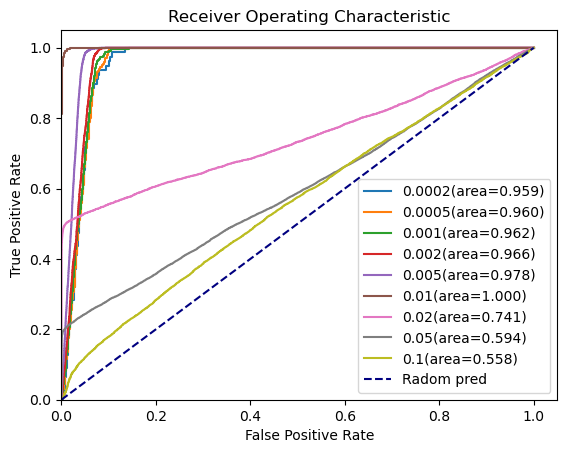

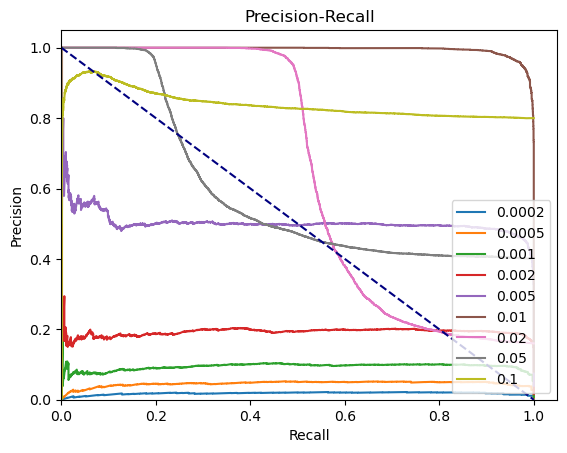

In [163]:
startIn= 3*len(identicalfs)
endIn= len(identicalfs)+startIn
evaluate.draw_auc_roc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], identicalfs)
evaluate.draw_prc(auc_rocs_aws[startIn: endIn], auc_rocs_preA[startIn: endIn], identicalfs)

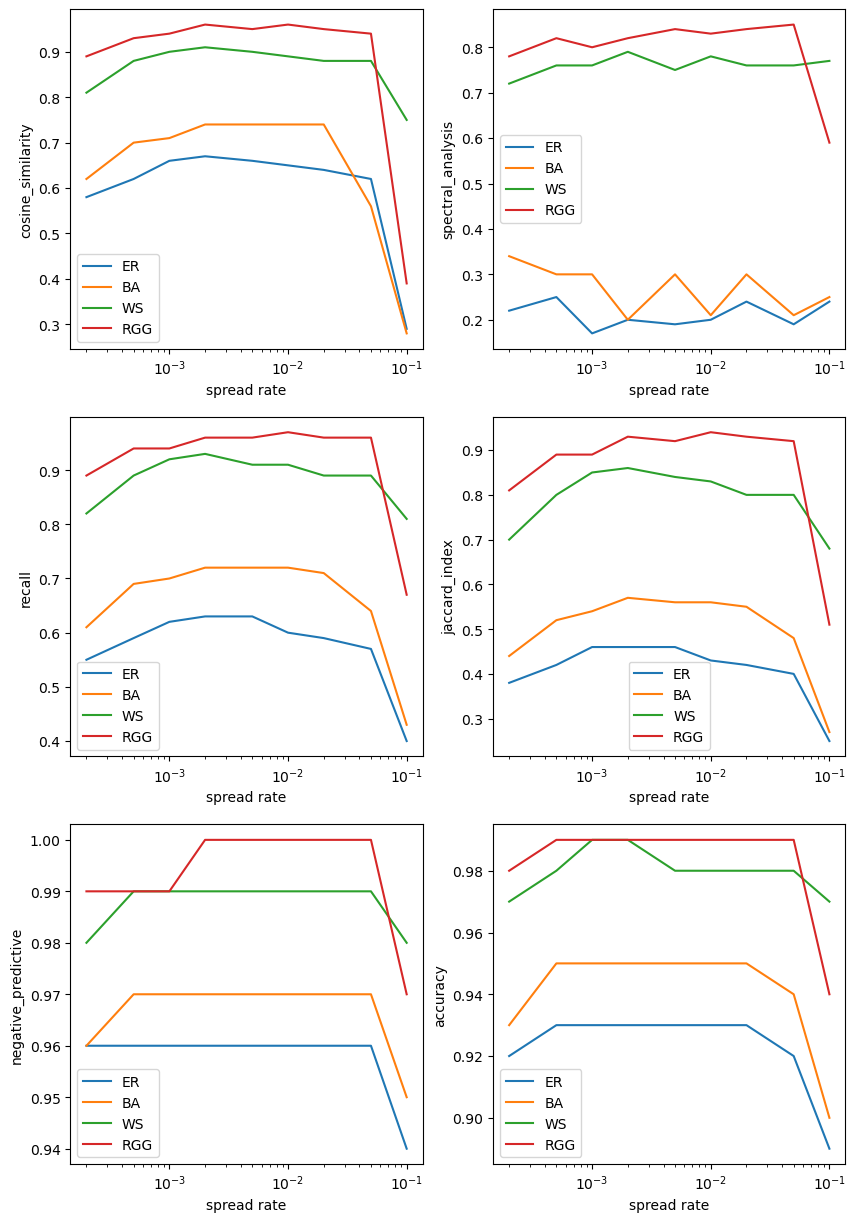

In [14]:
plot_evaluate(identicalfs, evaluateArray, "spread rate", yLabels, randomGraphs, "log")